### Get historical data 
read csv data file into a dataframe object

this is also where we take a subset of the data

Default setup is to trade on the first 92,000 minutes which is ~64 days. If you extend the time horizon, you will see the drop off in performance in the final plot.

In [2]:
import pandas
# history = pandas.read_csv('./binance_BTCUSDT_1m.csv') # bitcoin data
history = pandas.read_csv('./binance_DOGEBTC_1m.csv') # dogecoin data
# history = history.iloc[-5000:]
history = history.iloc[0:10000]
# history = history.iloc[1000000:1020000]  # extra hard
# history = history.iloc[1000000:]  # extra hard
history

from ta.utils import dropna
# Clean NaN values
history = dropna(history)

### Use ta to get a bunch of cool metrics about the stocks (these are not used but might be useful later)
ta code can be found [here](https://github.com/bukosabino/ta) and blog post can be found [here](https://towardsdatascience.com/technical-analysis-library-to-financial-datasets-with-pandas-python-4b2b390d3543)

In [3]:
from ta import add_all_ta_features
from ta.volatility import BollingerBands


def bolly(history, window, window_dev):
    # Add all ta features (takes like 10 minutes)
    # history = add_all_ta_features(
    #                 history, open="open", high="high", low="low", close="close", volume="volume")

    # Initialize Bollinger Bands Indicator
    indicator_bb = BollingerBands(close=history["close"], window=window, window_dev=window_dev)

    # Add Bollinger Bands features
    history['bb_bbm'] = indicator_bb.bollinger_mavg()
    history['bb_bbh'] = indicator_bb.bollinger_hband()
    history['bb_bbl'] = indicator_bb.bollinger_lband()

    # Add Bollinger Band high indicator
    history['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

    # Add Bollinger Band low indicator
    history['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

    # Add Width Size Bollinger Bands
    history['bb_bbw'] = indicator_bb.bollinger_wband()

    # Add Percentage Bollinger Bands
    history['bb_bbp'] = indicator_bb.bollinger_pband()
    
    return history

history = bolly(history, 20, 2)
history

,time,open,high,low,close,volume,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp
0,1562328000,4.200000e-07,4.300000e-07,3.500000e-07,3.800000e-07,364882194.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1,1562328060,3.900000e-07,4.000000e-07,3.800000e-07,3.800000e-07,323996565.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2,1562328120,3.800000e-07,4.000000e-07,3.800000e-07,4.000000e-07,152876988.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,1562328180,4.000000e-07,4.000000e-07,3.700000e-07,3.900000e-07,114541937.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN
4,1562328240,3.900000e-07,4.000000e-07,3.800000e-07,3.900000e-07,78344299.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,1562927520,2.800000e-07,2.800000e-07,2.800000e-07,2.800000e-07,3356.0,2.860000e-07,2.860000e-07,2.860000e-07,0.0,1.0,0.0,-inf
9993,1562927580,2.800000e-07,2.800000e-07,2.800000e-07,2.800000e-07,126948.0,2.860000e-07,2.860000e-07,2.860000e-07,0.0,1.0,0.0,-inf
9995,1562927700,2.800000e-07,2.900000e-07,2.800000e-07,2.900000e-07,54379.0,2.865000e-07,2.865000e-07,2.865000e-07,1.0,0.0,0.0,inf
9996,1562927760,2.800000e-07,2.800000e-07,2.800000e-07,2.800000e-07,83180.0,2.865000e-07,2.865000e-07,2.865000e-07,0.0,1.0,0.0,-inf


### Get price history from dataframe

In [4]:
col = 'open'     # name of column to get
p = history[col].tolist()  # price history

bb_bbh = history['bb_bbh'].tolist()
bb_bbl = history['bb_bbl'].tolist()
volume = history['volume'].tolist()

# p = p[0:10000]

t = list(range(len(p)))     # time variable

In [5]:
# these functions are used later
def avg(in_list):
    ma = 0
    num_el = len(in_list)
    
    ma = sum(in_list)
    ma = ma/num_el
    return ma

def ema(c, p, k, d):
    # EMA = (K x (C - P)) + P
    # C = Current Price
    # P = Previous periods EMA (A SMA is used for the first periods calculations)
    # K = Exponential smoothing constant
    # D = length of moving average in days
    return (c*k/(1+d))+p*(1-k/(1+d))

### Plot data

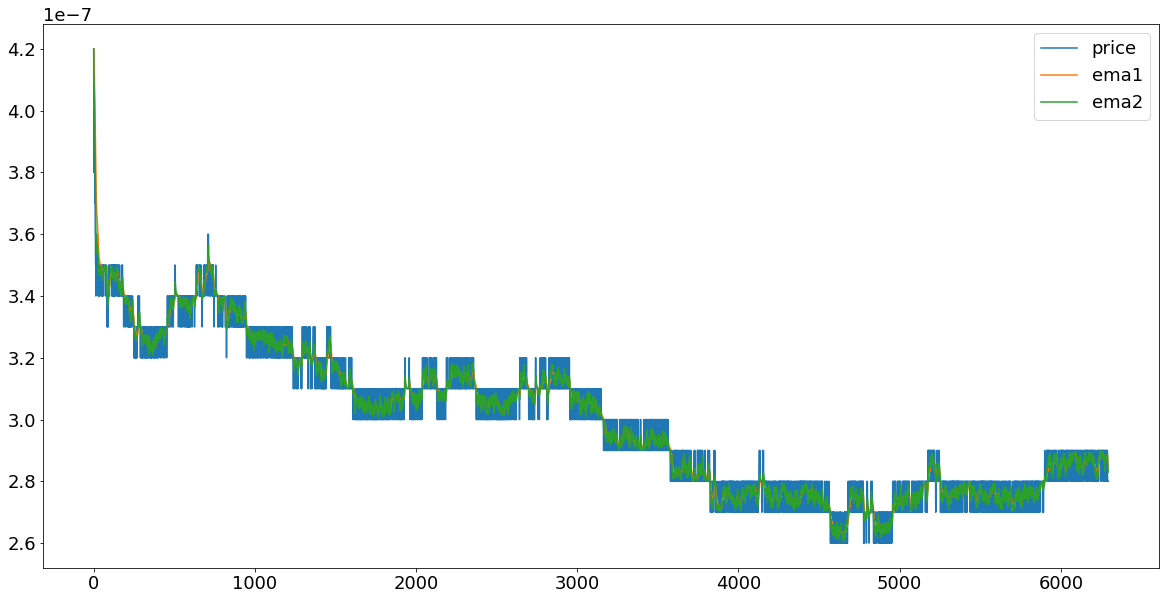

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 18})

ma = 1
ma1 = 0
ma2 = 0

sma_hist  = [0]*len(t)
ema_hist1 = [0]*len(t)
ema_hist2 = [0]*len(t)

smth1 = 0.1
smth2 = 0.2

for i in range(len(t)):
    if i == ma:
        ema_hist1[i] = avg(p[i-ma:i])
        ema_hist2[i] = avg(p[i-ma:i])
    elif i > ma:
        ema_hist1[i] = ema(p[i], ema_hist1[i-1], smth1, ma1)
        ema_hist2[i] = ema(p[i], ema_hist2[i-1], smth2, ma2)
    else:
        ema_hist1[i] = p[i]
        ema_hist2[i] = p[i]
    
plt.plot(t, p, label='price')
# ema
plt.plot(t, ema_hist1, label='ema1')
plt.plot(t, ema_hist2, label='ema2')
plt.legend()

### Find average maximum percentage after buy

# EMA CROSSOVER +EMA OPTIMIZER
this runs over the past n days (stored in list p) and finds the best ema crossover parameters (the length of each moving average, etc).

This is run quite frequently which leads to slow performance, but good trading performance.

In [10]:
def optimize(p):

    best_score = 0

    best_smth1=0 
    best_smth2=0

    best_d1 = 0
    best_d2 = 0

    net_worth = [0]*len(p)
    activity = [mean]*len(p)

    for j in range(0,10):
        for k in range(0,10):
            for l in range(0,10):
                for m in range(0,10):
                    cash = 100
                    doge = 0

                    d1 = j
                    d2 = k
                    
                    smth1 = l/10
                    smth2 = m/10

                    ema_hist1 = [0]*len(t)
                    ema_hist2 = [0]*len(t)

                    for i in range(len(p)):    # iterate through each day
                        price = p[i]

                        if i==0:
                            ema_hist1[i] = p[i]
                            ema_hist2[i] = p[i]

                        # trading logic

                        if i > 0:
                            ema_hist1[i] = ema(p[i], ema_hist1[i-1], smth1, d1)
                            ema_hist2[i] = ema(p[i], ema_hist2[i-1], smth2, d2)

                            percent_change = (price-prev_price)/prev_price
                            doge *= (1+percent_change)
                            
                            if (ema_hist2[i] < ema_hist1[i]):
                                # buy
                                if cash > 0:
                    #                 print(i, "buy!")
                    #                 print('    ',cash, "dollars")
                    #                 print('    ',doge, 'doge')
                                    doge += 0.999*cash
                                    cash -= cash
                    #                 print('    ',cash, "dollars")
                    #                 print('    ',doge, 'doge')
                                    activity[i] = buy

                            if (ema_hist2[i] > ema_hist1[i]):
                                # sell
                                if doge > 0:
                    #                 print(i, "sell!")
                    #                 print('    ',cash, "dollars")
                    #                 print('    ',doge, 'doge')
                                    cash += 0.999*doge
                                    doge -= doge
                    #                 print('    ',cash, "dollars")
                    #                 print('    ',doge, 'doge')
                                    activity[i] = sell

                        net_worth[i] = doge+cash
                        prev_price = price

                        if (i==len(p)-1):
                            if (doge+cash > best_score):
                                best_score = doge+cash
                                best_d1 = d1
                                best_d2 = d2
                                best_smth1 = smth1
                                best_smth2 = smth2
        #                         print("new best score!", str(doge+cash),'with parameters d1='+str(j),'d2='+str(k))
    
    return best_d1, best_d2, best_smth1, best_smth2


# d1, d2, smth1, smth2 = optimize(p[8000:16000])
# print(d1, d2)

### Run a backtest with the good parameters

In [11]:
# run the test with the final parameters
ma1 = 1

# starting state of the algorithm, $100, no doge
cash = 1      # variable to hold number of dollars
doge = 0        # variable to hold number of dogecoins

price = 0       # current price of doge
prev_price = 0  # previous price of doge

# values that will represent buying and selling in the history of our algorithm's activity,
# I chose these values so that we could plot it alongside the stock price (eg, with the same scale).
buy = max(p)
mean = avg(p)
sell = min(p)

# start with ok moving average parameters, these will be optimized as we go
# moving average smoothing parameters
smth1 = 0.1
smth2 = 0.1
# length of each moving average parameter
d1 = 1
d2 = 0

print('Parameters smth1='+str(smth1),'smth2='+str(smth2))
print('Parameters d1='+str(d1),'d2='+str(d2))

ema_hist1 = [0]*len(t)
ema_hist2 = [0]*len(t)

activity = [mean]*len(p)  # tells us when algo buys or sells
net_worth = [0]*len(p)  # how much money is in our account over time

progress = 0 # used for printing progress reports

for i in t:    # iterate through each day
    price = p[i]
    
    if i==0:
        ema_hist1[i] = p[i]
        ema_hist2[i] = p[i]
    
    if i%int(t[-1]/200)==0:
        print(str(progress)+'/200 of the way done')
        print('worth', str(cash+doge))
        progress += 1
    
    # optimize the trading parameters over the last 1000 minutes
    if i % 1001 == 0 :
        d1, d2, smth1, smth2 = optimize(p[i-1000:i])
    
    # trading logic
    if i > 0:
        ema_hist1[i] = ema(p[i], ema_hist1[i-1], smth1, d1)
        ema_hist2[i] = ema(p[i], ema_hist2[i-1], smth2, d2)

        percent_change = (price-prev_price)/prev_price
        doge *= (1+percent_change)
        
        if (ema_hist2[i] < ema_hist1[i]):
            # buy all doge
            if cash > 0:
                doge += 0.999*cash
                cash -= cash
                activity[i] = buy

        if (ema_hist2[i] > ema_hist1[i]):
            # sell all doge
            if doge > 0:
                cash += 0.999*doge
                doge -= doge
                activity[i] = sell

    net_worth[i] = doge+cash
    prev_price = price

Parameters smth1=0.1 smth2=0.1
Parameters d1=1 d2=0
0/200 of the way done
worth 1
1/200 of the way done
worth 1.0
2/200 of the way done
worth 1.0
3/200 of the way done
worth 1.0
4/200 of the way done
worth 1.0
5/200 of the way done
worth 1.0
6/200 of the way done
worth 1.0
7/200 of the way done
worth 1.0
8/200 of the way done
worth 1.0
9/200 of the way done
worth 1.0
10/200 of the way done
worth 1.0
11/200 of the way done
worth 1.0
12/200 of the way done
worth 1.0
13/200 of the way done
worth 1.0
14/200 of the way done
worth 1.0
15/200 of the way done
worth 1.0
16/200 of the way done
worth 1.0
17/200 of the way done
worth 1.0
18/200 of the way done
worth 1.0
19/200 of the way done
worth 1.0
20/200 of the way done
worth 1.0
21/200 of the way done
worth 1.0
22/200 of the way done
worth 1.0
23/200 of the way done
worth 1.0
24/200 of the way done
worth 1.0
25/200 of the way done
worth 1.0
26/200 of the way done
worth 1.0
27/200 of the way done
worth 1.0
28/200 of the way done
worth 1.0
29/

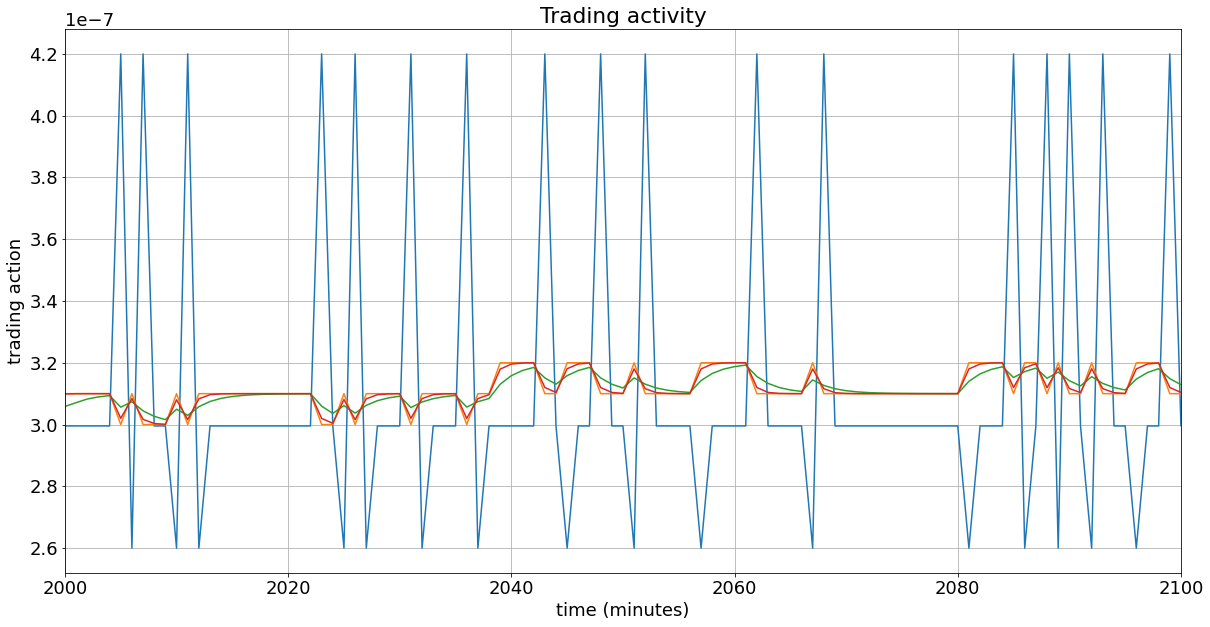

In [12]:
# plot the activity along with the stock price
plt.plot(t, activity)
plt.plot(t, p)
plt.plot(t, ema_hist1)
plt.plot(t, ema_hist2)
plt.xlim([2000, 2100])
plt.xlabel('time (minutes)')
plt.ylabel('trading action')
plt.title('Trading activity')
plt.grid(True)
plt.show()

net worth with hold strategy -33.33333333333333
net worth with moving average strategy 16169446127391.514


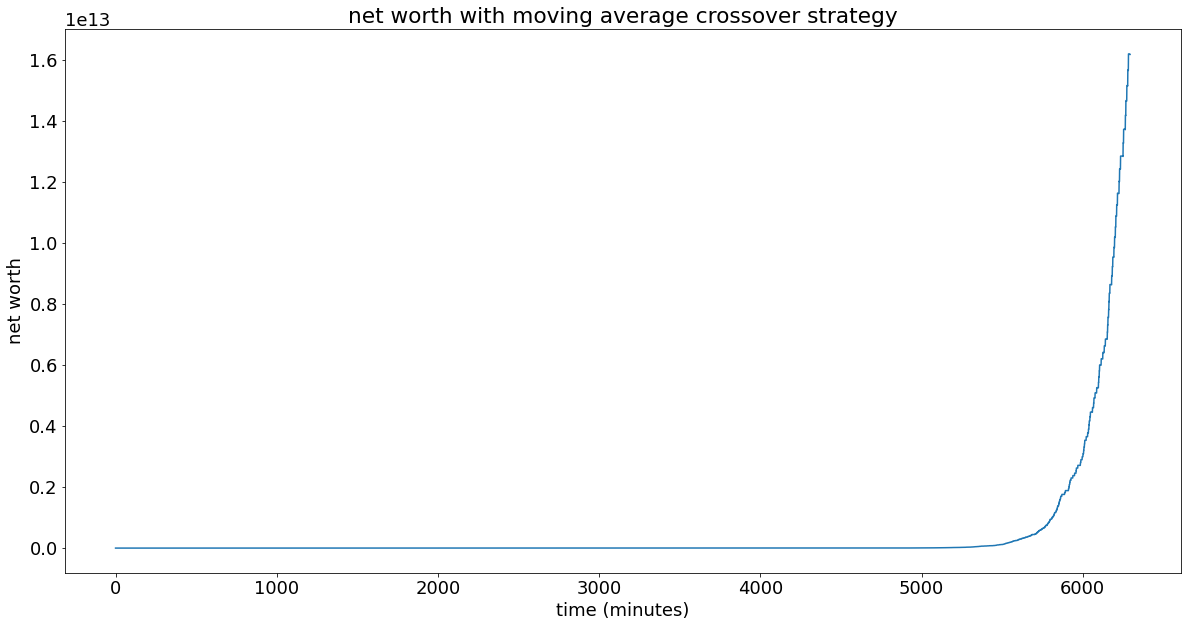

In [13]:
# plot the net worth of the trading strategy over time

# compare the trading strategy to buying at the beginning and doing nothing/holding
hold = 100*(p[-1]-p[0])/p[0]
print('net worth with hold strategy', str(hold))
print('net worth with moving average strategy', str(net_worth[-1]))
plt.plot(t, net_worth)
plt.title('net worth with moving average crossover strategy')
plt.xlabel('time (minutes)')
plt.ylabel('net worth')
plt.show()